# Selective Capacitated Fair Pickup and Delivery Problem - Part II


## 0.) Introduction, setup & code layout

### Code Setup

we begin by implementing all the necessary pyackages, as well as the functions and classes defined in other files

In [1]:
from src.instance import Instance
from src.misc import *
from src.route import Route
from src.solution import Solution
from src.alns import *
from src.alns_ai_improved_v2 import *
from src.aco import *
from src.plots import *
import os
import numpy as np
import copy
import pandas as pd
from scipy.stats import wilcoxon

We have defined three classes _Instance_, _Route_, and _Solution_ to hold metainformation about the instance we are dealing with as well as to streamline the way our algorithms deal with underlying data strucutres.
* **Instance:**
The Instance class represents a problem instance and stores all static input data, including the number of requests and vehicles, vehicle capacity, minimum service level, fairness parameter, depot location, and pickup–delivery coordinates with associated demands. It provides functionality to parse and load instance files and serves as a read-only data container throughout the algorithm.

* **Route:**
The Route class models the route of a single vehicle as an ordered sequence of pickup and delivery nodes. It maintains derived route information such as load profiles, remaining capacity slack, and total route length, and provides methods for feasibility checks, incremental cost evaluation, and local modifications (e.g., insertion and removal of requests), which are heavily used by destroy and repair operators. To make this more efficient, these methods are using delta-evaluation.

* **Solution:**
The Solution class represents a complete solution consisting of one route per vehicle, together with global information such as total distance, fairness value, overall objective cost, and the set of unserved requests. It supports solution-level operations including feasibility checks, cost recomputation, fast lookup of request-to-route assignments, visualization, and exporting solutions in the required output format.

The following code snippet demonstrates how the Instance class is used, how we can apply an algorithm to an instance class, and how we can initialize the routes and solution class:

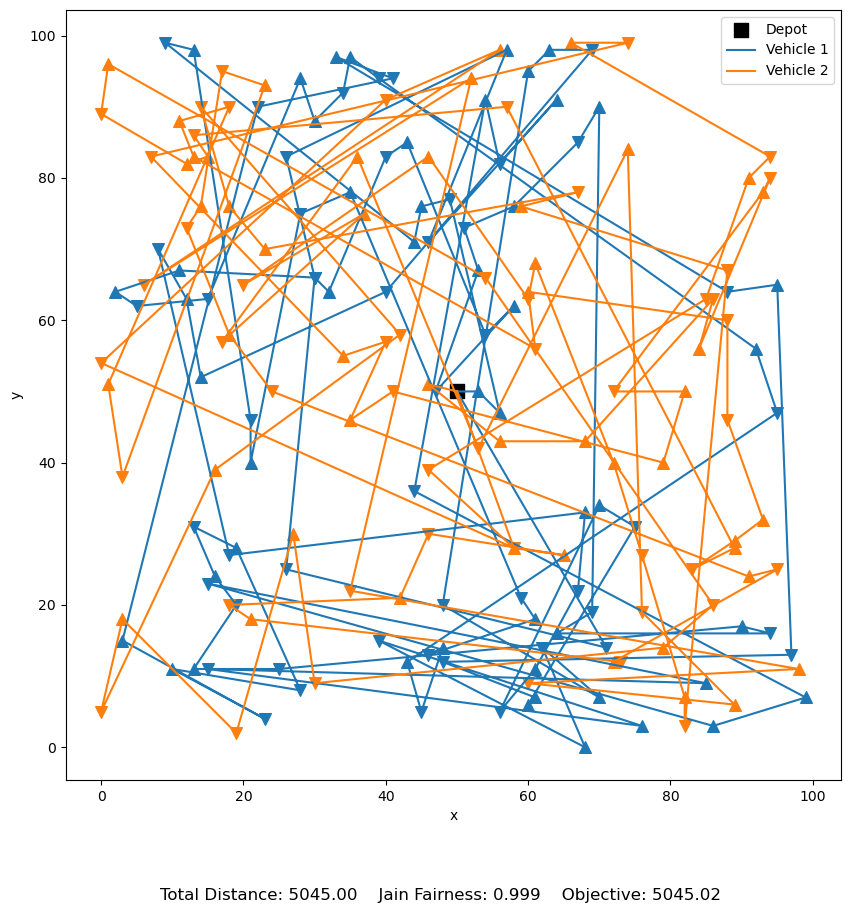

In [2]:
instance = Instance("instances/100/competition/instance61_nreq100_nveh2_gamma91.txt")
s0 = Solution(instance) #initializig initial solution
routes_array = nearest_neighbor_heuristic(instance) # since the NN-constr.heur. is imported from the 1st assignment, it does not natively include the new data structures yet and returns arrays
s0.load_from_arrays(routes_array) # thus we initialize the routes & solutions with arrays
s0.plot() # the solution class offers the possibility to plot the results in an intuitive way

## 1.) Implementing two algorithms

## Adaptive Large Neighborhood Search
We implement an Adaptive Large Neighborhood Search (ALNS) framework that iteratively improves an initial feasible solution by alternating between destroy and repair phases. In each iteration, a subset of requests is removed using one of several destroy operators (random, worst, Shaw-related, or heavy-demand removal), after which feasibility is restored using either a greedy or a regret-3 insertion heuristic. Operator selection is governed by adaptive weights that are periodically updated based on their empirical success rates, enabling the algorithm to balance diversification and intensification dynamically.

Candidate solutions are accepted according to a simulated annealing criterion, allowing controlled acceptance of worsening moves to escape local optima, while improvements are always accepted and tracked as the current best solution. Throughout the search, detailed iteration-level statistics—including objective value, operator usage, acceptance decisions, runtime, and temperature—are logged to facilitate post hoc performance analysis and operator diagnostics.

We have created a class to store the parameters for the ALNS in a convenient way. This is helpful for later, because we can test different configurations for this algoritm more easily. Down below is an example how to use this algorithm:

In [3]:
params = ALNSParams(
    T0=10.0,          # Initial temperature
    cooling=0.975,      # Cooling rate
    destroy_fraction=10,  # how many of the nodes get destroyed in each iteration
    rho=0.25,           # Reaction factor (also sometimes called gamma)
    reward_best=7.0,   # Reward for finding a new best solution
    reward_accept=0.0, # Reward for accepting a solution
    reward_reject=-2.0, # Reward for rejecting a solution
    max_gap = 20,   # maximum distance between pick up and drop off
    regret_k = 2 #this is actually hardcoded, modifying this doesn't change anything
)

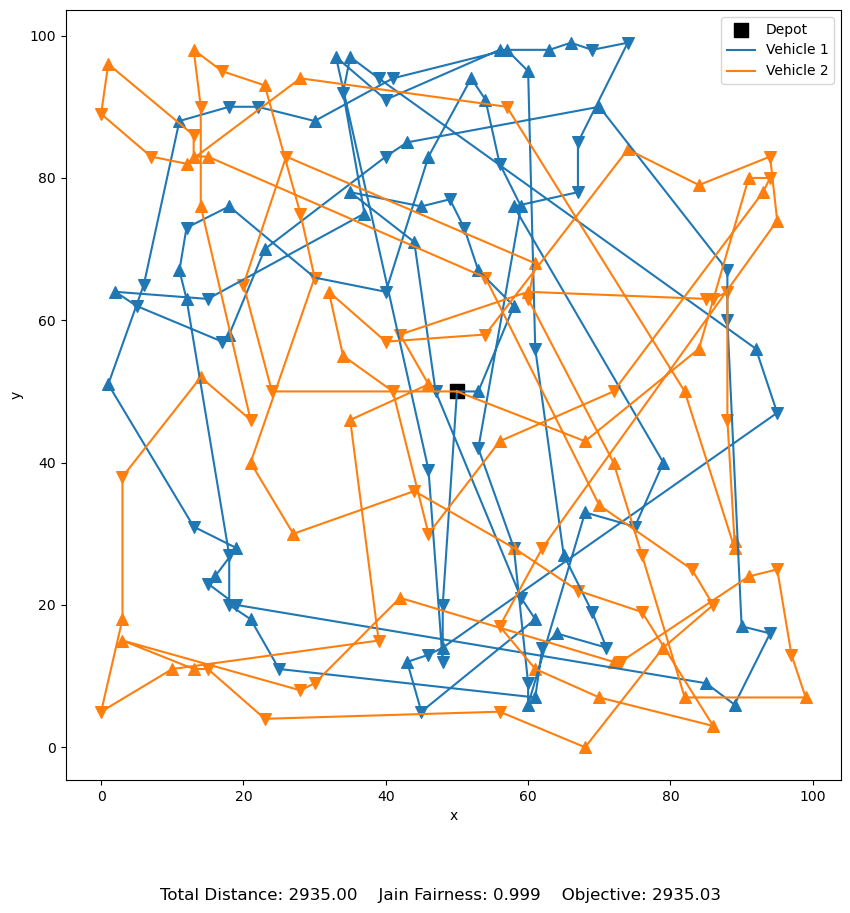

In [4]:
new_s = alns(instance, s0,params ,iters = 2000)
new_s.plot()

### Performance of ALNS
After optimizing the parameters for ALNS, tried to analyze the performance by creating some plots:

In [5]:
# Load the CSV file into a DataFrame
df = pd.read_csv("alns_log.csv")

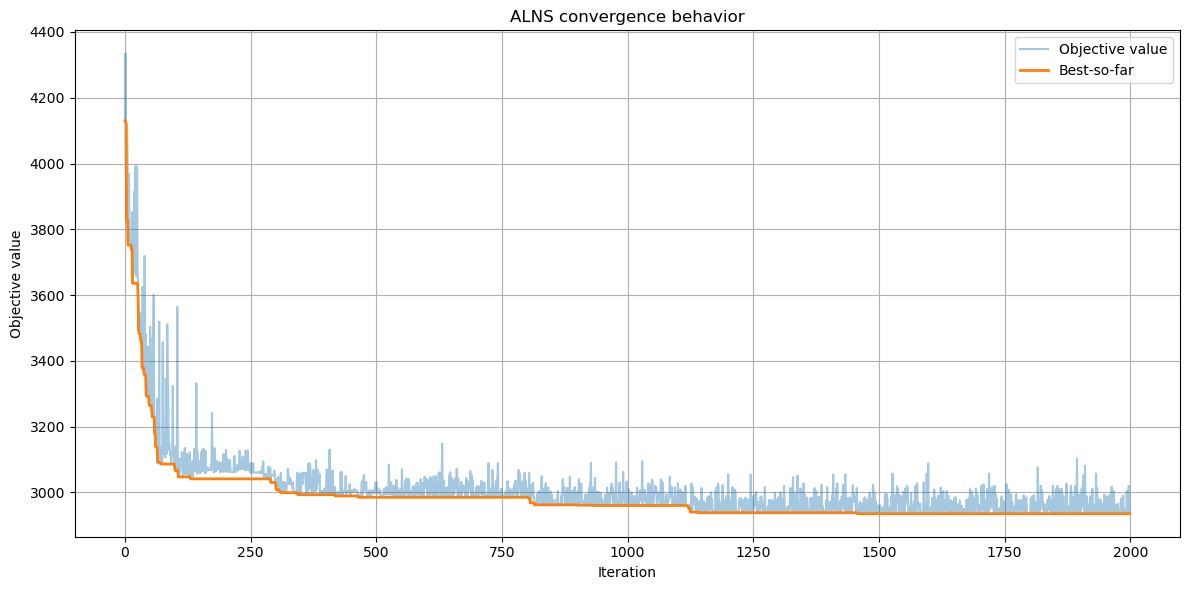

In [6]:
plot_objective_vs_iteration(df)

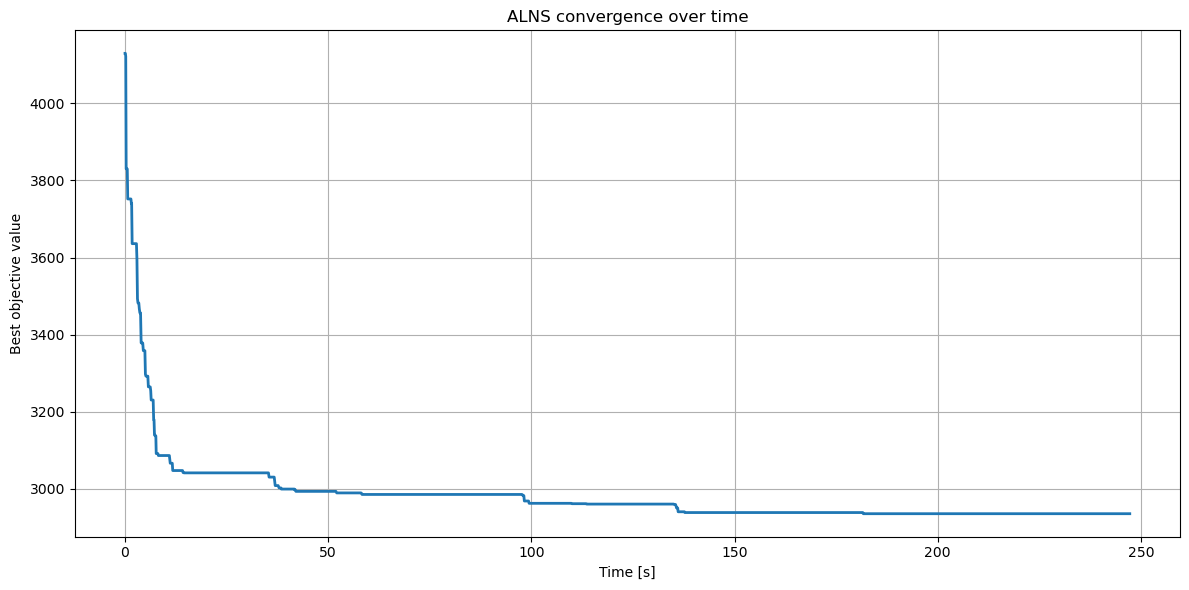

In [7]:
plot_objective_vs_time(df)

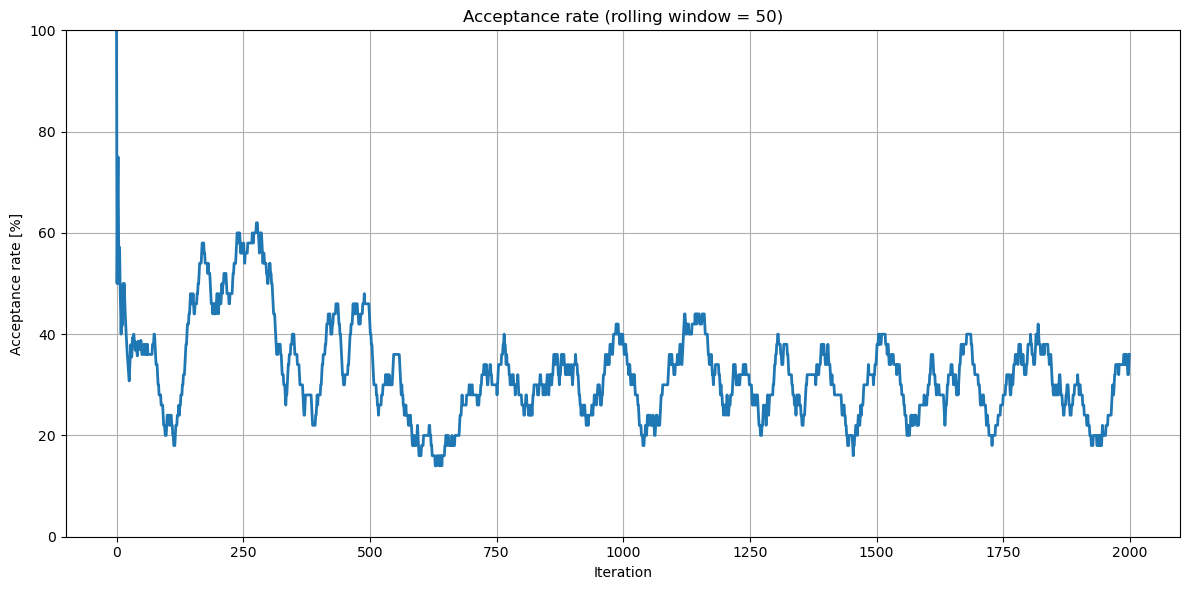

In [8]:
plot_acceptance_rate(df, 50)

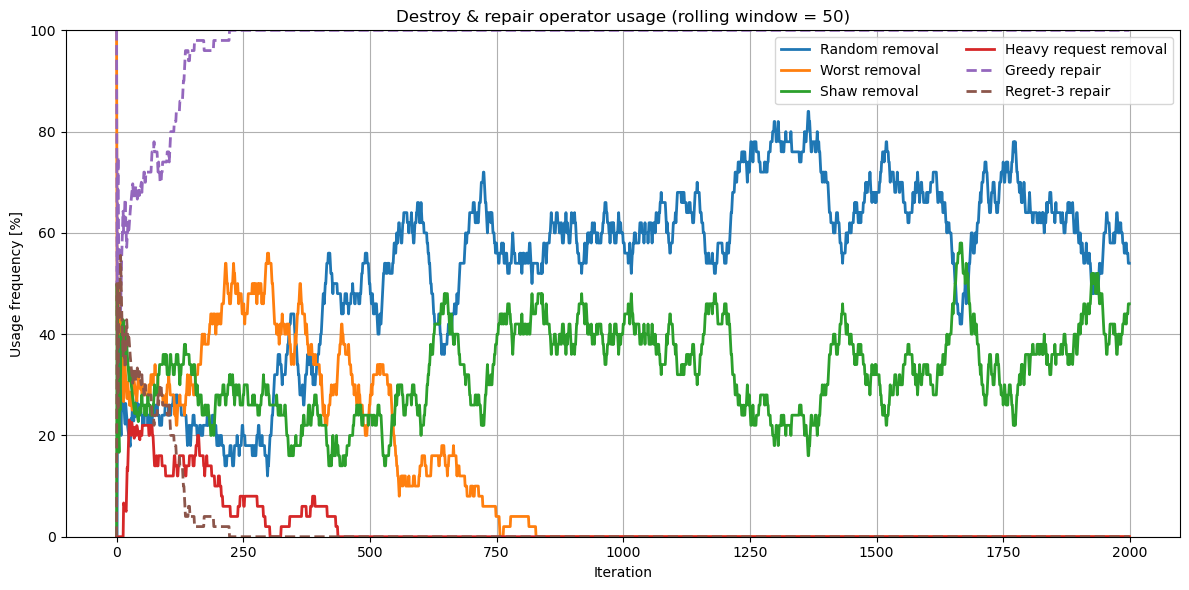

In [9]:
plot_operator_usage_combined(df, 50)

### How can we improve the performance of our ALNS algorithm?
Obviously, we want to achieve the best possible performance on the competition instances. On TUWEL, we can see that significantly better results are possible for ALNS. This sparked our motivation, and we wonder: How can we further improve our results? Some ideas:

* **Better Operators:** The questions which operators to choose is key in ALNS. Beyond the ones we implemented, we encountered a technique called "Slack Induction by String Removals". The key idea behind this technique is creating an operator that removed contiguous sequences of request from the route to create capacity slack, making it easier for the repair phase to find better global rearrangements than with isolated removals. This approach showed great results for VRP as well as pickup-and-delivery problems. [Source](https://www.jstor.org/stable/10.2307/27369088)
* **✨AI✨:** The operator selection in the ALNS algorithm is right now done by roulette wheel selection, which is very inefficient. A lot of current research focuses on improving this aspect, especially with ✨AI ✨. A simple example would be training a simple neural network on offline data and then using it to decide which operators to use in which situation. But there are also more fancy approaches, using e.g. deep reinforcement learning ([Source](https://ieeexplore.ieee.org/document/10660531)). However, ML techniques only become more efficient as the operator pool increases, and it s unclear whether the increased operator selection efficiency really outweighs the increased training time.
* **Parameter tuning:** Another promising approach is parameter tuning. Given that we initially have no clue how the optimal paramters for such a complex algorithm look like, and that we have to do this anyway for the next subtask, this seems like a good idea.

## Ant Colony Optimization

To complement the ALNS, we implemented a *MAX-MIN Ant System (MMAS)*, a robust variant of ACO specifically designed to avoid premature convergence. Our implementation, FastUltraACO, is tailored to handle the multi-vehicle Pickup and Delivery constraints while explicitly optimizing for fairness.

#### 1. Core Logic: The Ant's Decision Process
Each "ant" constructs a solution by iteratively selecting the next move (a pickup or a drop-off) for one of the $n_k$ vehicles. The selection is stochastic, governed by a probability distribution based on several factors:
* *Pheromone Trails ($\tau$):* Represent "collective memory," where paths that were part of globally high-quality solutions in previous iterations receive more pheromone.
* *Heuristic Information ($\eta$):* Represents "local greediness," calculated using the inverse of the distance to the next target.
* *Fairness Penalty:* To specifically target fairness, we added a penalty to the heuristic: nodes that would cause a vehicle's distance to deviate significantly from the current fleet average are penalized.

The probability of choosing a move is proportional to $(\tau^\alpha) \cdot (\eta^\beta)$, where $\alpha$ and $\beta$ control the influence of memory versus local intuition.

#### 2. MMAS Features and Stagnation Control
Standard ACO often suffers from "stagnation," where all ants follow the same suboptimal path. Our MMAS implementation prevents this through:
* *Pheromone Bounds $[t_{min}, t_{max}]$:* Pheromones are strictly clipped within a range, ensuring that even the "worst" paths maintain a non-zero probability of exploration.
* *Global Best Update:* Only the best ant found since the start of the algorithm is allowed to deposit pheromones, focusing the search on the most promising regions.
* *Smoothing:* If the algorithm does not improve for 20 iterations (stagnation), the pheromone trails are partially reset toward $t_{max}$ to force new exploration.

#### 3. Integration of Local Search (2-opt)
To further refine the solutions generated by the ants, we integrated a *2-opt Local Search* algorithm.

* *Refinement Strategy:* To maintain computational efficiency, the local search is applied only to the *best ant of each iteration* rather than every ant.
* *Mechanism:* The local_search_2opt method iteratively swaps the edges of a route to determine if the path distance can be reduced.
* *Feasibility Checks:* Every 2-opt swap is followed by a feasibility check to ensure the modified route still adheres to the vehicle's capacity constraints.
* *Objective Recalculation:* After the local search is complete, the solution's total distance and fairness are recomputed using the specified measure (e.g., Jain, Max-Min, or Gini) to determine if it has surpassed the global best solution.

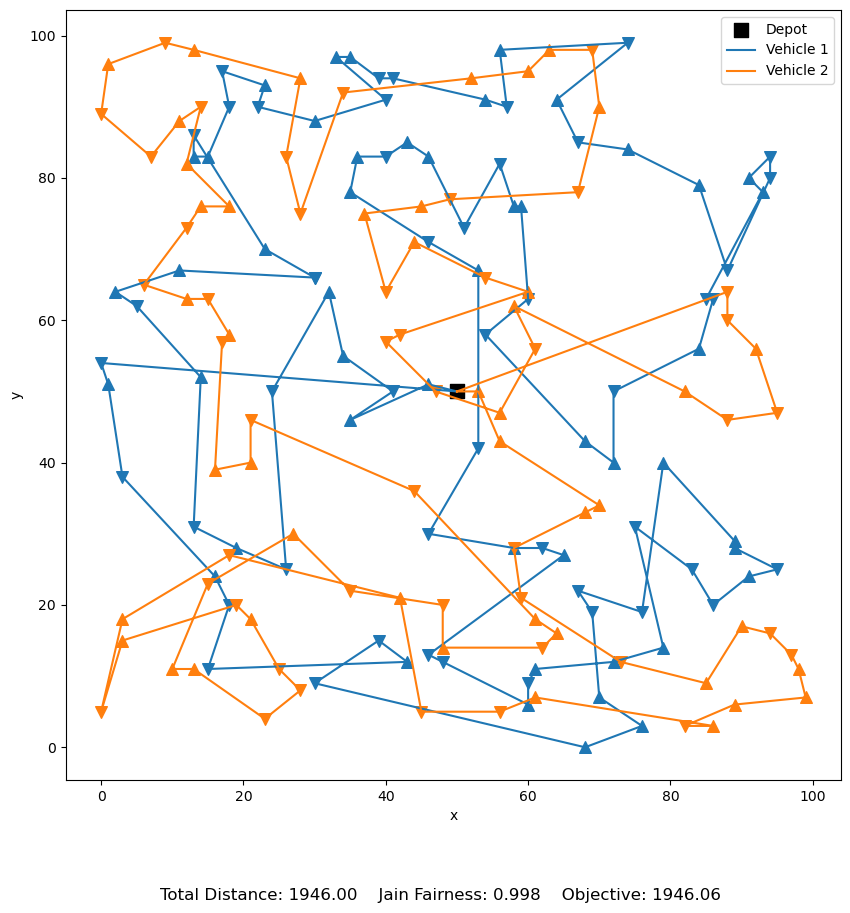

In [10]:
aco = FastUltraACO(instance, alpha=2.0, beta=6.0, rho=0.1, m_ants=20, cand_size=30)
best_sol = aco.run(iterations=50)
best_sol.plot()

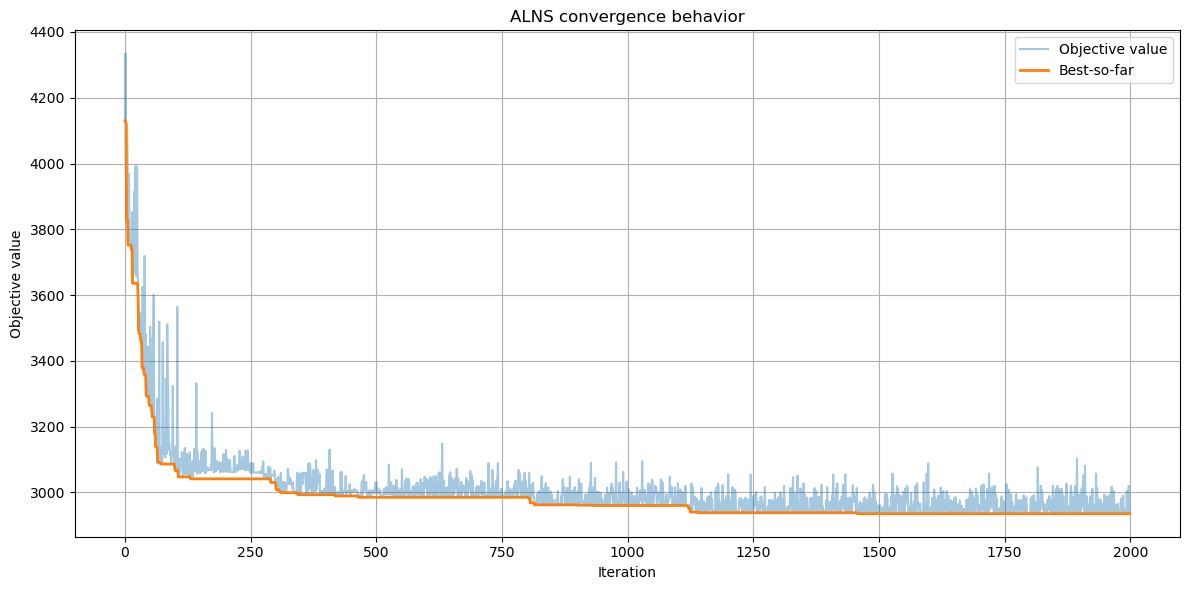

In [11]:
plot_objective_vs_iteration(df)

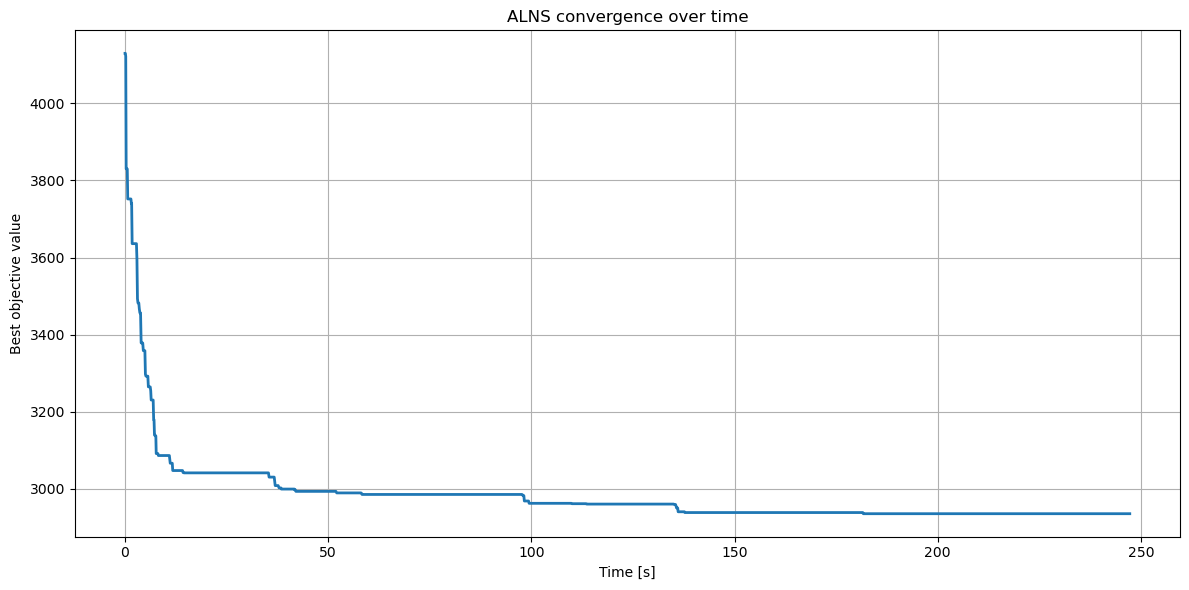

In [12]:
plot_objective_vs_time(df)

## 2.) Experimenting with different fairness mesaures

## Investigation Results and Analysis

In this task, we investigated how changing the fairness measure in the objective function affects the solution quality (Objective Value) and the workload distribution (Number of Stops). We compared the standard **Jain's Fairness Index** against **Max-Min Fairness** and the **Inverted Gini Coefficient**.

### 1. Mathematical Definitions

We replaced the fairness term $J(R)$ in the objective function $f(s) = \text{TotalDistance} + \rho \cdot (1 - \text{Fairness})$ with:

* **Max-Min Fairness ($M$):** Focuses on the ratio between the shortest and longest route.
    $$M = \frac{\min_{k \in K} d(R_k)}{\max_{k \in K} d(R_k)}$$
* **Inverted Gini Coefficient ($G$):** Measures the inequality across all pairs of routes.
    $$G = 1 - \frac{\sum_{i} \sum_{j} |d(R_i) - d(R_j)|}{2 \cdot n_K \cdot \sum_{k} d(R_k)}$$

### 2. Quantitative Comparison

To obtain meaningful insights into the distribution behaviors, we moved beyond small toy instances and tested on larger configurations, specifically **$n=50$ requests with 10 vehicles** and **$n=100$ requests with 20 vehicles**. We found that instances with only 2 vehicles were insufficient to show significant differences in distribution patterns.

However, investigating these larger instances introduced significant challenges regarding **computational time**. The complexity of the SCF-PDP scales rapidly with the number of vehicles and requests, which limited the extent of our experimental runs. Additionally, we observed that the **Inverted Gini Coefficient** is the most complex measure to optimize. Unlike Max-Min (which only checks the extremes) or Jain (which relies on sums), the Gini coefficient requires calculating pairwise differences between *all* routes, making the evaluation of each move in the algorithm more computationally intensive.

Based on these experiments, we observed the following behaviors:

| Optimization Goal | Total Distance | Workload Balance (Stops) | Fairness Sensitivity |
| :--- | :--- | :--- | :--- |
| **Jain's Index** | **Lowest (Best)** | Moderate Variance | **Balanced:** Penalizes variance but allows outliers for global efficiency. |
| **Max-Min** | **Highest (Worst)** | Low Variance (Uniform) | **Strict:** The solution is limited by the "weakest link" (shortest/longest route). Forces inefficient detours to equalize lengths. |
| **Gini (Inv)** | **Intermediate** | Low Variance | **Holistic:** Considers gaps between *all* drivers, leading to a robustly distributed workload, though hardest to compute. |

### 3. Analysis of "Objective Value" and "Stops"

**How does the Objective Value change?**
Optimizing for **Max-Min** generally leads to a worse (higher) Objective Value compared to Jain. This is because the Max-Min constraint is extremely restrictive. To maximize the $\frac{\min}{\max}$ ratio, the algorithm must often skip profitable, distant requests or force vehicles to take inefficient paths to artificially align the route lengths. Furthermore, **Max-Min** only considers the best and the worst vehicle; the distribution of all vehicles in between is irrelevant to the score. Jain's index, being a softer metric, allows for slight inequalities if they result in significant distance savings.

**How does the Number of Stops change?**
There is a strong correlation between route distance and the number of stops.
* **Under Jain:** We often observe "clustering." One driver might serve a dense city center (many stops, short distance) while another serves rural areas (few stops, long distance). The distances might be similar, but the *stop count* varies significantly.
* **Under Max-Min/Gini:** The algorithm is forced to distribute the "load" more evenly across the entire fleet of 10 or 20 vehicles. To achieve equal distances, the *number of stops* often converges, resulting in a much smaller range between the minimum and maximum stops per vehicle.

### 4. Conclusion
While **Max-Min** provides the strictest guarantee of equality, it comes at a high cost in terms of total fleet distance and solution quality. **Jain's Index** remains the most practical measure for the SCF-PDP as it balances fairness with economic efficiency. The **Gini Coefficient** offers a robust alternative if a more uniform distribution than Jain is desired, though it comes with higher computational complexity.

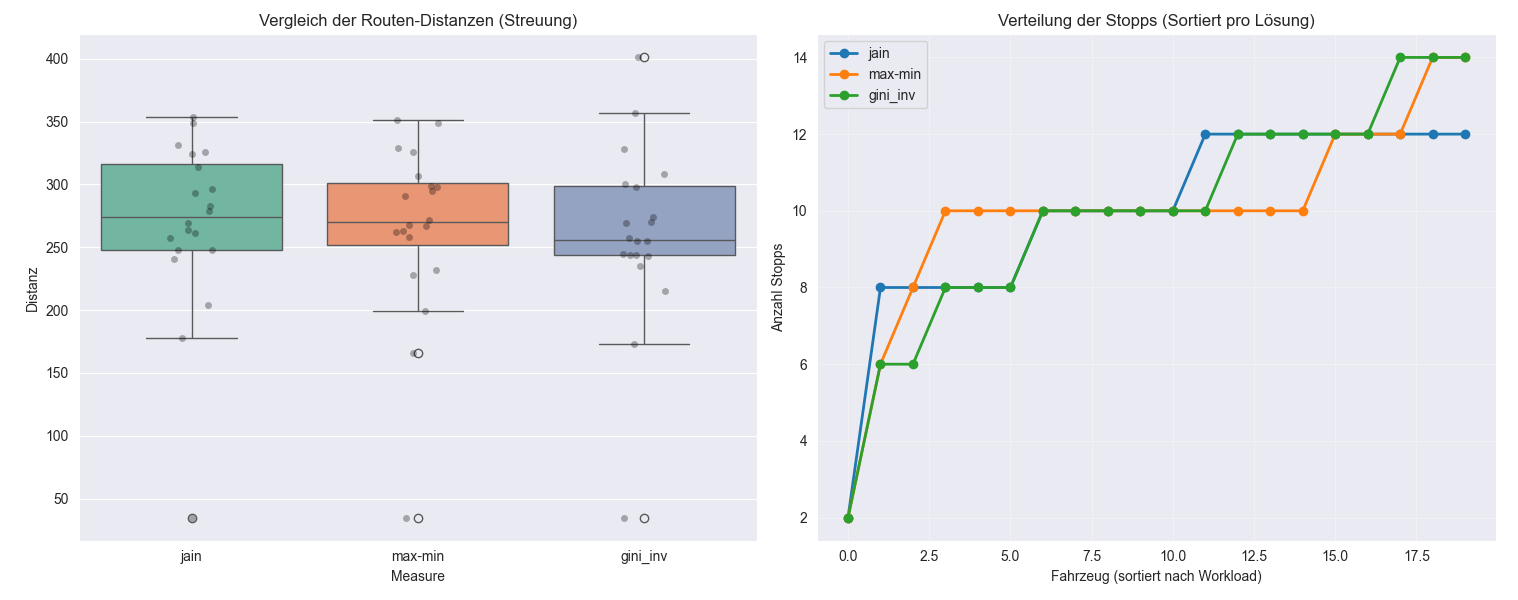
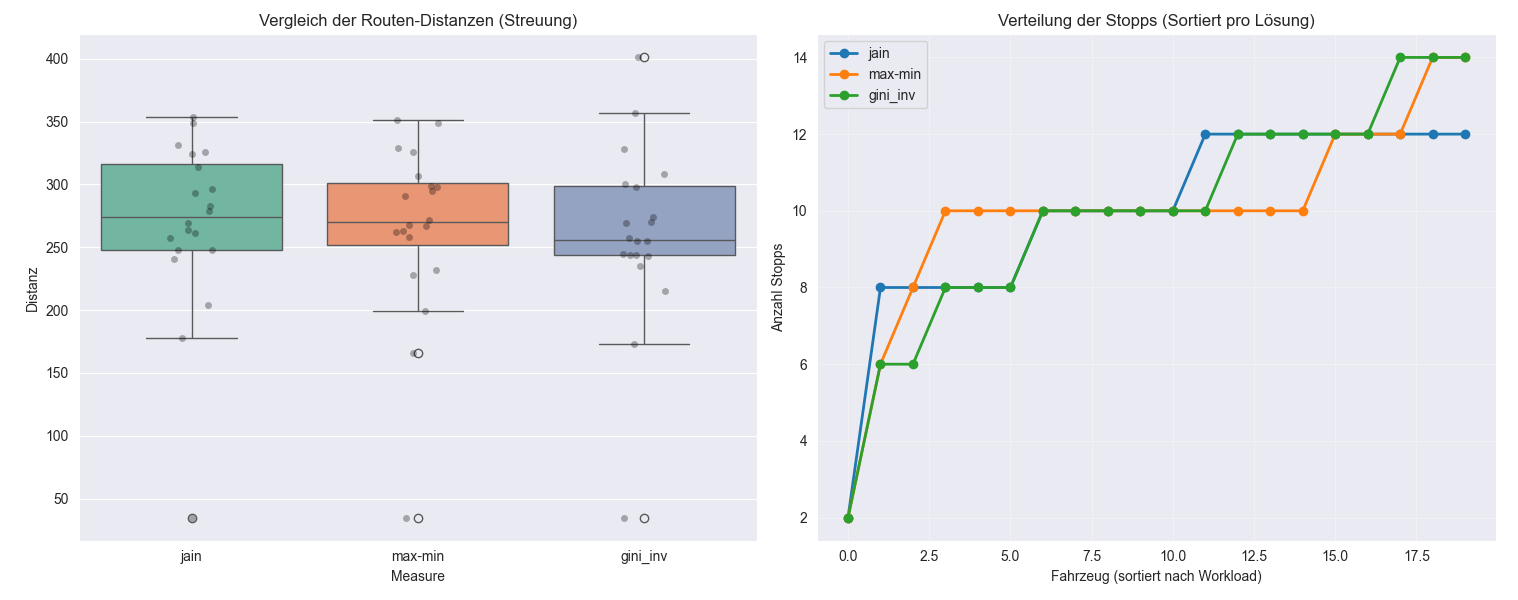
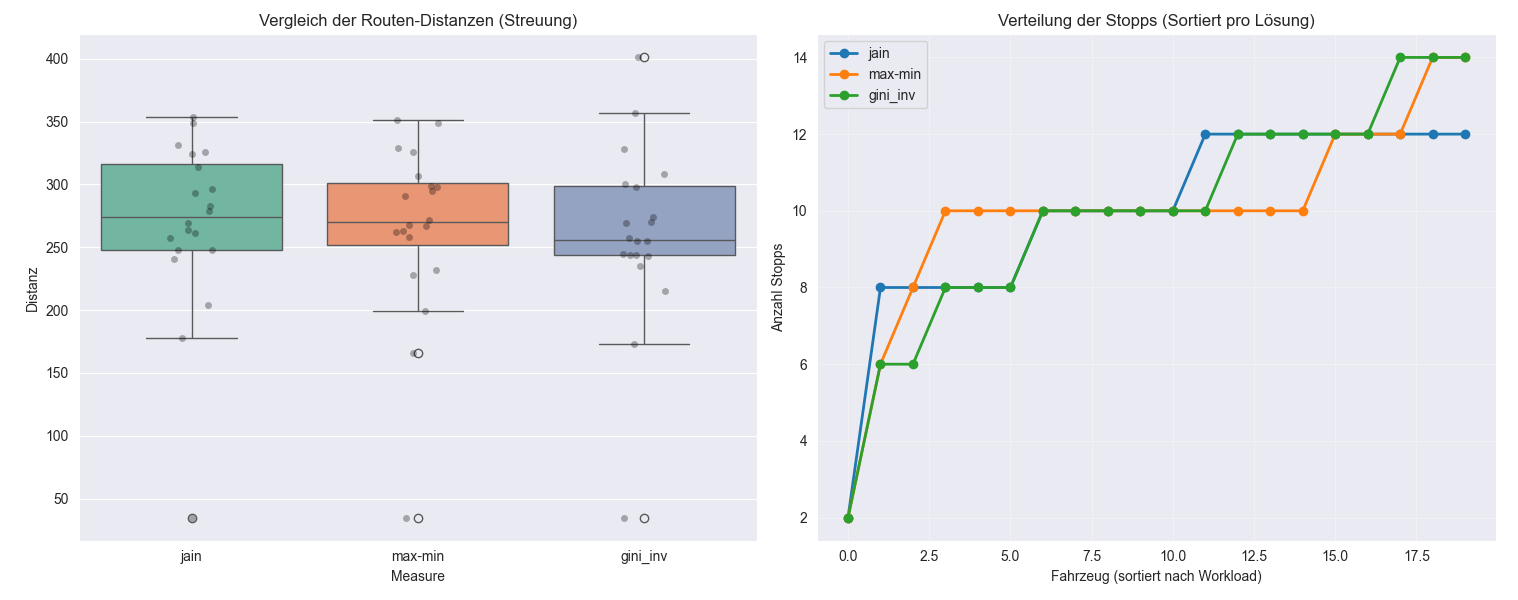

## 3.) Tuning our algorithms

### Tuning ALNS parameters
We use the irace package as introduced in the lecture slides to find the optimal parameter configuration. We run tests on all instances for n = 100, and set a maximum time limit of 10h. We test the following parameter values:

| Parameter        | Values                                                                                     |
|------------------|-------------------------------------------------------------------------------------------|
| T0              | 10, 15, 20, 25, 30, 40, 50                                                                |
| cooling         | 0.95, 0.975, 0.99                                                                          |
| destroy_fraction| 2, 3, 5, 7, 10, 15, 20, 25, 30, 35, 40                                                    |
| rho             | 0.25, 0.5, 0.65, 0.75, 0.9                                                                |
| reward_best     | 2, 5, 6, 7, 0                                                                              |
| reward_accept   | 0, 1, 2                                                                                   |
| reward_reject   | -2, -1, 0                                                                                  |
| max_gap         | 3, 5, 7, 10, 15, 20, 25, 30, 35, 40                                                       |
| iters           | 100, 200, 300, 400, 500, 1000, 1500, 2000                                                |

Some parameters, like destroy_fraction or iters, strongly influence the runtime of the algorithm. Since we only have limited time, we want to force the algorithm to find the best possible solution in the shortest possible time. We thus set a maximum time per ALNS run of 2.5 minutes - if the algorithm exceed this time, it gets stopped and received a large penalty objective score of 5000. This design forces irace to trade off solution quality against computational efficiency, as faster configurations can perform more iterations within the time limit, while slower configurations are penalized. Furthermore, training on all 30 test instances forces irace to create robust configurations. With an average time of 169 seconds per run, the tuning procedure took about 7h in total.

These were the best configurations irace came up with:

| T0  | cooling | destroy_fraction | rho  | reward_best | reward_accept | reward_reject | max_gap | iters |
|-----|---------|-------------------|------|-------------|---------------|----------------|---------|-------|
| 10  | 0.975   | 7                 | 0.25 | 7           | 0             | -2             | 7       | 2000  |
| 25  | 0.975   | 7                 | 0.25 | 7           | 0             | -2             | 7       | 1500  |
| 10  | 0.975   | 10                | 0.25 | 7           | 0             | -2             | 7       | 1500  |
| 40  | 0.95    | 7                 | 0.5  | 7           | 1             | -2             | 7       | 500   |
| 10  | 0.95    | 10                | 0.25 | 7           | 2             | -2             | 7       | 1500  |

We observe a consistent trend across the elite configurations. Effective parameter settings tend to use a relatively low initial temperature combined with a medium to fast cooling rate, a medium destroy fraction, and a low value of ρ. Furthermore, a high reward for the best action and a fixed medium insertion window length (max_gap=7) appear to be particularly important, as they are shared by all top configurations. Finally, configurations with a high number of iterations consistently perform well, indicating that—within the imposed time limit—solution quality benefits more from additional iterations than from more aggressive parameter settings.

Furhtermore, we were thinking about the following question: How does the runtime of our algorithm change with the instance size n? This question is particularly important because we want to estimate how long it would take us to find the optimal parameter configurations (the tuning for n=100 was already quite time consuming with a runtime over 7h). To better estimate this, we ran the following experiment: We picked randomly 3 instances for each n, ran them three times for 100 iterations, with the optimal configuration we found earlier for n=100, and calculated the average and min and max values. We also tried to fit the data with a power law function. We thus suggest that the runtime for 100 iterations of our ALNS algorithm can be modeled with the following formula:
$$
\boxed{T_{100}(n) \approx 1.496\cdot 10^{-03} \cdot n^{1.776}}
$$

Looking at the graph below and at the formula, we can see that while the runtime for n=100 for 100 iteration is between 4 and 5 seconds, the mean runtime for n=1000 is lready at ~300s. For n=2000, it is already over 1000s. This shows that tuning for larger instances would take drastically more time and was thus not prioritised.

Fitted model: T(n) ≈ 1.496e-03 · n^1.776


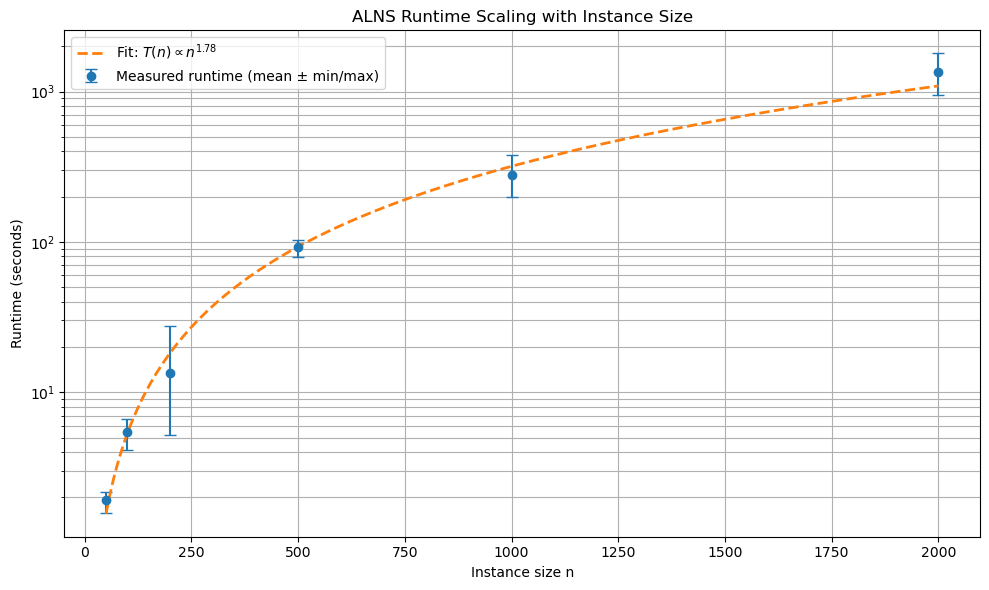

In [3]:
scaling_plot()

### Tunign ACO
Similarly, ACO was also tuned with irace, testing the following parameter ranges:


| Parameter | Values                                           |
|-----------|--------------------------------------------------|
| alpha     | 0.5, 0.75, 1.0, 1.25, 1.5, 2.0                   |
| beta      | 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0                |
| rho       | 0.01, 0.02, 0.03, 0.05, 0.07, 0.10, 0.12, 0.15   |
| m_ants    | 10, 15, 20, 25, 30, 35, 40                       |
| cand_size | 10, 15, 20, 25, 30                               |
| iters     | 30, 40, 50, 60, 70                               |

These were the best configurations irace came up with:

| alpha | beta | rho  | m_ants | cand_size | iters |
|-------|------|------|--------|-----------|-------|
| 2.0   | 6.0  | 0.10 | 20     | 30        | 50    |
| 2.0   | 6.0  | 0.10 | 25     | 20        | 40    |
| 0.5   | 5.0  | 0.01 | 25     | 25        | 30    |
| 1.0   | 6.0  | 0.07 | 20     | 30        | 50    |

Similarily to the example above, we tested the scaling behaviour of our ACO algorthm. We can for sure say that the scaling behaviour is worse, already for n=1000 it is an order of magnitude slower than ALNS.

Fitted model: T(n) ≈ 1.062e-02 · n^1.966


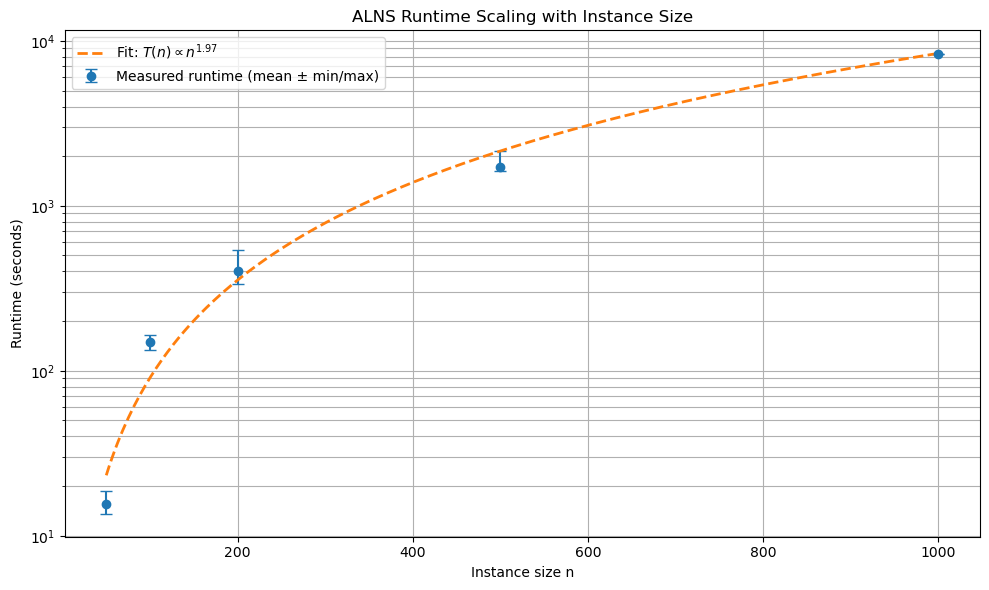

In [3]:
scaling_plot2()

## 4.) Testing our algortihms

We test our algorithms from this assignment (ACO & ALNS) as well as the most promisin galgorithm from last assignment (Beam Search) on all instances for n = 100. Results for the objective value and the runtime per algorithm can be seen below. For ALNS & ACO, the most optimal parameter configurations that were found with irace were used. For beam search, we used beta = 200

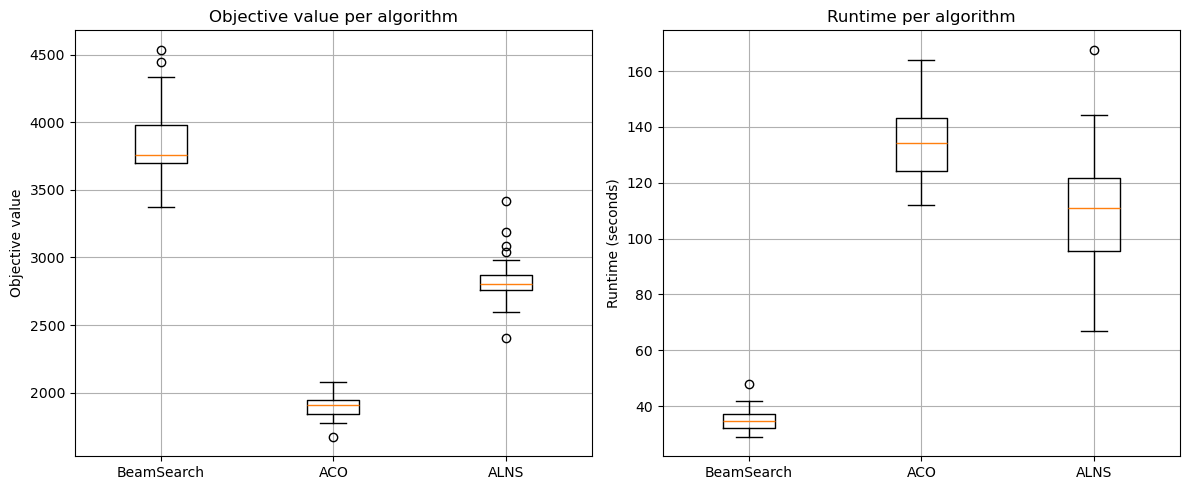

In [3]:
plot_algorithm_boxplots("src/test_results_n100.csv")

## 5.) Comparing algorithms

We compare both alorithms using a Wilcoxon signed rank-test to see whether the ACO is really better than the ALNS. Unsurprisingly, we get a clear p value.

In [4]:
df = pd.read_csv("src/test_results_n100.csv")
df = df[df["algorithm"].isin(["ALNS", "ACO"])]

pivot = (
    df.pivot(index="instance", columns="algorithm", values="objective")
    .dropna()
)

alns = pivot["ALNS"]
aco = pivot["ACO"]

# Wilcoxon signed-rank test
stat, p_value = wilcoxon(alns, aco, alternative="two-sided")

print(f"Wilcoxon statistic: {stat:.3f}")
print(f"p-value: {p_value:.4g}")

Wilcoxon statistic: 0.000
p-value: 1.863e-09
